# Best Secret Data Science Task

1. Ingestion of Data
2. Data Preprocessing (Missing Values, Datetime Conversion) / Feature Engineering
3. Analysis
4. ID List

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.ensemble import IsolationForest

# Ingestion of Data

In [122]:
df = pd.read_csv('bestsecret_analysis_test_data.csv')

In [123]:
df.head()

,CUSTOMER_ID,CUSTOMER_CREATED_TIMESTAMP,CUSTOMER_GENDER,CUSTOMER_REGISTRATION_CHANNEL,INVITER_CUSTOMER_ID,QTY_ORDERS,REVENUE,FIRST_ORDER_DATE,LAST_ORDER_DATE
0,1,2012-10-08 11:49:43.755,male,other,NaN,0,NaN,NaN,NaN
1,2,2013-08-26 15:44:11.173,female,viral,42921.0,0,NaN,NaN,NaN
2,3,2014-02-08 20:42:39.698,male,viral,42922.0,11,754.0499,2014-09-25 00:00:00.000,2017-01-29 00:00:00.000
3,4,2014-02-09 07:48:45.611,male,other,NaN,0,NaN,NaN,NaN
4,5,2014-04-02 01:09:20.439,female,viral,42923.0,0,NaN,NaN,NaN


In [124]:
df.isna().sum()

CUSTOMER_ID                          0
CUSTOMER_CREATED_TIMESTAMP           0
CUSTOMER_GENDER                    217
CUSTOMER_REGISTRATION_CHANNEL        1
INVITER_CUSTOMER_ID              35233
QTY_ORDERS                           0
REVENUE                          41121
FIRST_ORDER_DATE                 41121
LAST_ORDER_DATE                  41121
dtype: int64

In [125]:
df[['QTY_ORDERS', 'REVENUE']].describe()

,QTY_ORDERS,REVENUE
count,42920.000000,1799.000000
mean,0.263141,611.762281
std,4.966952,5383.434035
min,0.000000,-4.161300
25%,0.000000,39.264200
50%,0.000000,90.550100
75%,0.000000,283.166650
max,752.000000,214924.369500


# Data Preprocessing

For those customers, who haven't made an order yet, I use the logic of putting the user creation timestamp as a filler, which will be useful in the next step to create the time deltas.

In [126]:
df['FIRST_ORDER_DATE'] = df['FIRST_ORDER_DATE'].fillna(df['CUSTOMER_CREATED_TIMESTAMP'])
df['LAST_ORDER_DATE'] = df['LAST_ORDER_DATE'].fillna(df['CUSTOMER_CREATED_TIMESTAMP'])
df[['CUSTOMER_GENDER', 'CUSTOMER_REGISTRATION_CHANNEL']] = df[['CUSTOMER_GENDER', 'CUSTOMER_REGISTRATION_CHANNEL']].fillna('NA')
df[['REVENUE', 'INVITER_CUSTOMER_ID']] = df[['REVENUE', 'INVITER_CUSTOMER_ID']].fillna(0)

Next, we deal with outliers as we saw that some values in Quantity Orders and Revenue Colums seem unrealistically high or lower than 0.

Outliers are a tricky topic, because oftentimes a statistical outlier might not be an outlier from a business perspective and vice versa. Outliers can often be valid, uncorrupted data, which simply represents an edge case for a business. Still, outliers can have a negative impact on a model performance and analysis, so I have chosen to remove a conservative amount using an algorithmic approach as my domain and business knowledge is limited. A huge advantage of the isolation forest algorithm is that it can tackle outliers in a multivariate fashion, which comes in very handy for bigger dimension datasets.

Please note that Isolation Forest is unsupervised, so applying it on the whole data set will not result in data leakage!

We aim to remove around 0.2% of the data. The 0.2% threshold is a heuristic measure, which for the purpose of this showcase should be a good measure.

In [127]:
def isolation_outlier(df, cont, cols=None):
    print('dataset with outliers:', len(df))
    isof = IsolationForest(max_samples=1000, contamination=cont/100)
    if cols == None:
        isof.fit(df.select_dtypes(include=np.number))
        listpred = isof.predict(df.select_dtypes(include=np.number))
    else:
        isof.fit(df[cols])
        listpred = isof.predict(df[cols])
    df['outlier'] = listpred
    df = df.loc[df['outlier'] == 1]
    df.drop('outlier', axis=1, inplace=True)
    print('dataset without outliers:', len(df))
    return df

In [128]:
df = isolation_outlier(df, 0.2, cols=['REVENUE', 'QTY_ORDERS'])

dataset with outliers: 42920


/Users/d/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


dataset without outliers: 42834


/Users/d/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


While the upper end outliers have been dealt with, the below 0 "outliers" (which statistically aren't outlier, but do not make logical sense) have persisted for Revenue, so we manually set every value smaller than 0 to 0

In [129]:
df[['QTY_ORDERS', 'REVENUE']].describe()

,QTY_ORDERS,REVENUE
count,42834.000000,42834.000000
mean,0.135733,9.249071
std,1.149576,95.063282
min,0.000000,-4.161300
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,50.000000,6821.937800


In [130]:
rev = []
for row in df.REVENUE.iteritems():
    if row[1] < 0:
        rev.append(0)
    else:
        rev.append(row[1])

In [131]:
df['REVENUE'] = rev
df['REVENUE'].describe()

count    42834.000000
mean         9.249866
std         95.063198
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6821.937800
Name: REVENUE, dtype: float64

After converting the date columns into the datetime format, we then engineer the new features by calculating the delta between the account creation date and the date of the last order as well as the delta between the first and latest order in days.

Further we engineer the features revenue per order (total revenue/quantity of orders) and revenue per day (total revenue / days between account creation and last order)  

In [132]:
df['CUSTOMER_CREATED_TIMESTAMP'] = pd.to_datetime(df['CUSTOMER_CREATED_TIMESTAMP'])
df['FIRST_ORDER_DATE'] = pd.to_datetime(df['FIRST_ORDER_DATE'])
df['LAST_ORDER_DATE'] = pd.to_datetime(df['LAST_ORDER_DATE'])

df['days_created_last_ord'] = (df['LAST_ORDER_DATE'] - df['CUSTOMER_CREATED_TIMESTAMP']).dt.days
df['days_first_last_ord'] = (df['LAST_ORDER_DATE'] - df['FIRST_ORDER_DATE']).dt.days

df['rev_per_order'] = df['REVENUE'] / df['QTY_ORDERS']
df['rev_per_day'] = df['REVENUE'] / df['days_created_last_ord']

In [133]:
df[['rev_per_order', 'rev_per_day']] = df[['rev_per_order', 'rev_per_day']].fillna(0)

we now use the pandas implementation of one hot encoding on the registration channel to represent it numerically.

In [134]:
oh_channel = pd.get_dummies(df['CUSTOMER_REGISTRATION_CHANNEL'])
df = df.join(oh_channel)

We also one hot encode the gender, so that we have a numerical representation of it. I did this manually to show my ability to use for-loops.

In [135]:
isfem = []
for row in df['CUSTOMER_GENDER'].iteritems():
    if row[1] == 'female':
        isfem.append(1)
    else:
        isfem.append(0)
df['isfemale'] = isfem
#df = df.drop('CUSTOMER_GENDER', axis=1)

In order to get the count of invitations sent out by an user, we use the value count method to get the inviter ID and the corresponding number of invites sent out by the specific ID. We then save it as a dataframe to later merge it with the rest of the data.

In [136]:
id_counts = df['INVITER_CUSTOMER_ID'].value_counts().to_frame(name='invite_count')

Let's cut the dataframe down to the necessary features

In [137]:
df_shrt = df[['CUSTOMER_ID', 'CUSTOMER_REGISTRATION_CHANNEL', 'QTY_ORDERS', 'REVENUE', 'days_created_last_ord', 'days_first_last_ord',
              'isfemale','rev_per_order', 'rev_per_day', 'affiliate', 'other', 'partnerprogram', 'viral']]

Last, we merge the invite counts with the rest of the features

In [138]:
df_final = pd.merge(df_shrt, id_counts, left_on='CUSTOMER_ID', right_on=id_counts.index, how='left')
df_final['invite_count'] = df_final['invite_count'].fillna(0)

On the last check, we again notice that for the days_created_last_ord column, we have -1 as the lowest value, which does not make sense as you cannot place an order before creating your account, so again we set every value lower than 0 to 0.

In [139]:
df_final[['QTY_ORDERS', 'REVENUE', 'days_created_last_ord', 'days_first_last_ord']].describe()

,QTY_ORDERS,REVENUE,days_created_last_ord,days_first_last_ord
count,42834.000000,42834.000000,42834.00000,42834.000000
mean,0.135733,9.249866,11.14234,7.171149
std,1.149576,95.063198,104.66169,82.677266
min,0.000000,0.000000,-1.00000,0.000000
25%,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.00000,0.000000
max,50.000000,6821.937800,2693.00000,2505.000000


In [140]:
dclo = []
for row in df.days_created_last_ord.iteritems():
    if row[1] < 0:
        dclo.append(0)
    else:
        dclo.append(row[1])

In [141]:
df_final['days_created_last_ord'] = dclo
df_final['days_created_last_ord'].describe()

count    42834.000000
mean        11.148737
std        104.660978
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2693.000000
Name: days_created_last_ord, dtype: float64

# Analysis

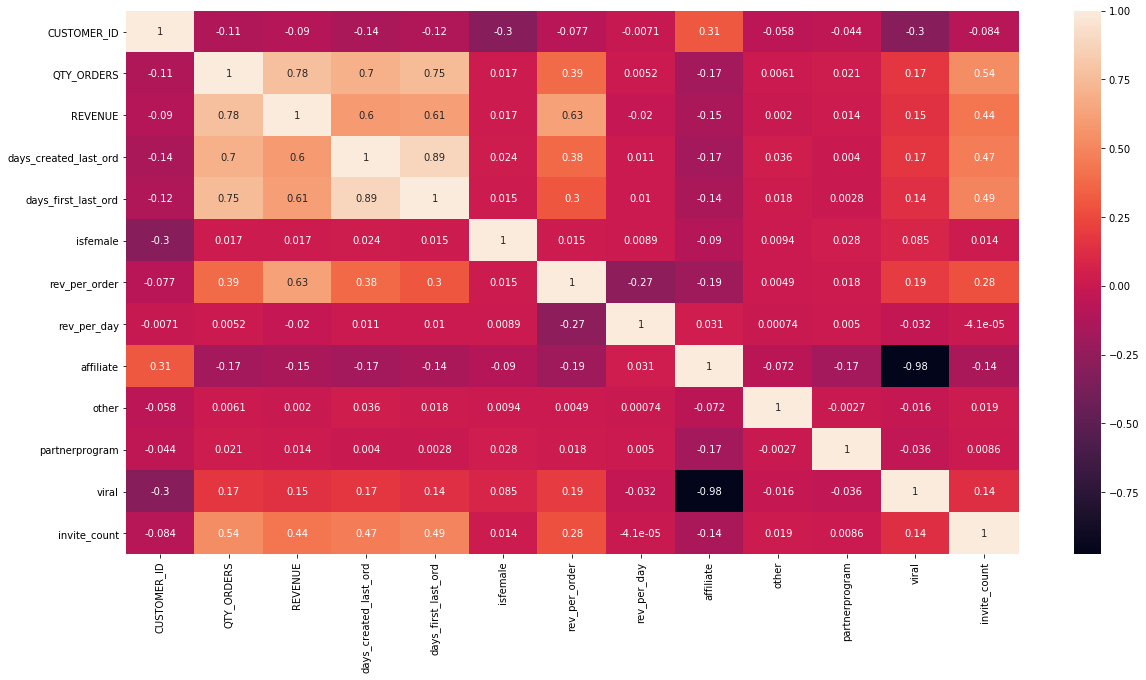

In [142]:
cm = df_final.corr()
plt.rcParams["figure.figsize"] = (20,10)


sn.heatmap(cm, annot=True)
plt.show()

Now, according to the wording of the task, we should sort the ID's by invite count as well as Revenue and Order Quantity as we want to target users that "show potential", who haven't invited other users so far (List B)

On the other hand, the above matrix shows that the invite count has some decent correlation with other features like 'days between first and last order', 'days between account creation and last order', 'number of orders by account' and 'revenue' (List A)


My idea would be to actually AB Test both lists against each other to see which approach yields better performance. Unfortunately, the task didn't mention specific KPIs or metrics by which performance is determined, so that would be something that would need to be clarified ahead of the test.


I have not shortened the lists, just sorted them because the task didn't specify how many users should be targeted. If the marketeers for example want to target 1000 users, they can simply take the first 1000 users of the list.

In [143]:
df_a = df_final.sort_values(['invite_count', 'QTY_ORDERS', 'days_first_last_ord', 'days_created_last_ord', 'REVENUE'],
                            ascending = (True, False, False, False, False))

df_a_ids = df_a['CUSTOMER_ID'].reset_index(drop=True)


df_b = df_final.sort_values(['invite_count', 'REVENUE', 'QTY_ORDERS'], 
                            ascending = (True, False, False))

df_b_ids = df_b['CUSTOMER_ID'].reset_index(drop=True)

In [144]:
df_a_ids.to_csv('BS_List_A.csv', index=False, header='ID')
df_b_ids.to_csv('BS_List_B.csv', index=False, header='ID')